In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import cvxpy as cp
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models, EfficientFrontier

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [21]:
# load the dataset
data = pd.read_csv('../../data/definitive_dataset.csv')

# convert date columns to date with no time
data['date'] = pd.to_datetime(data['date'])

In [22]:
data.drop_duplicates(inplace=True)

In [23]:
def create_date_permno_column(data):
    
    # convert date to datetime
    data['date'] = pd.to_datetime(data['date'])

    # keep only the date
    data['date'] = data['date'].dt.date

    # create a column that is the concatenation of date and permno
    data['date_permno'] = data['date'].astype(str) + '_' + data['permno'].astype(str)

    return data

In [24]:
# load the price data
price_data = pd.read_csv('../../data/backtest_prices.csv')

# create a new column in the price data that is permno
price_data = create_date_permno_column(price_data)

# change the name of the prc_adj column to price
price_data.rename(columns={'prc_adj': 'price'}, inplace=True)

print('Price data columns:', price_data.columns)
print('Head of price data:', price_data.head())

Price data columns: Index(['date', 'permno', 'prc', 'cfacpr', 'cfacshr', 'divamt', 'adj_prc',
       'adj_prc_w_dividend', 'Ticker', 'date_permno'],
      dtype='object')
Head of price data:          date  permno    prc    cfacpr  cfacshr  divamt    adj_prc  \
0  2008-12-09   10145  27.68  1.047784      1.0     0.0  26.417659   
1  2006-06-01   10137  36.52  1.000000      1.0     0.0  36.520000   
2  2006-06-02   10137  36.92  1.000000      1.0     0.0  36.920000   
3  2006-06-05   10137  36.48  1.000000      1.0     0.0  36.480000   
4  2006-06-06   10137  36.39  1.000000      1.0     0.0  36.390000   

   adj_prc_w_dividend Ticker       date_permno  
0           26.417659    HON  2008-12-09_10145  
1           36.520000    AYE  2006-06-01_10137  
2           36.920000    AYE  2006-06-02_10137  
3           36.480000    AYE  2006-06-05_10137  
4           36.390000    AYE  2006-06-06_10137  


In [25]:
price_data.drop_duplicates(inplace=True)

In [26]:
price_data.rename(columns={'adj_prc': 'price'}, inplace=True)

In [27]:
# count negative prices
print('Number of negative prices:', price_data[price_data['price'] < 0].shape[0])
print('Mean of negative prices:', price_data[price_data['price'] < 0]['price'].mean())

# remove negative prices
price_data = price_data[price_data['price'] >= 0]

Number of negative prices: 0
Mean of negative prices: nan


In [28]:
# load the features as pickle
with open('../../data/selected_features_2.pkl', 'rb') as f:
    features = pkl.load(f)

# print the keys
print(features.keys())

dict_keys([Timestamp('2008-01-01 00:00:00'), Timestamp('2010-01-01 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2016-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00')])


In [29]:
# drop rows with missing target value
data.dropna(subset=['target'], inplace=True)

In [30]:
# define starting dates for the periods
training_starting_dates = ['2008-01-01','2010-01-01', '2012-01-01', '2014-01-01', '2016-01-01', '2018-01-01']

In [31]:
def find_first_trading_day(date, data, direction, consider_current_date=True):

    first_date = data['date'].min()
    last_date = data['date'].max()
    
    if not consider_current_date:
        if direction == 'forward':
            date = date + pd.DateOffset(days=1)
        elif direction == 'backward':
            date = date - pd.DateOffset(days=1)
    
    while date not in data['date'].values:
        if direction == 'forward':
            date = date + pd.DateOffset(days=1)
            if date > last_date:
                return last_date
        elif direction == 'backward':
            date = date - pd.DateOffset(days=1)
            if date < first_date:
                return first_date
    return date

c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


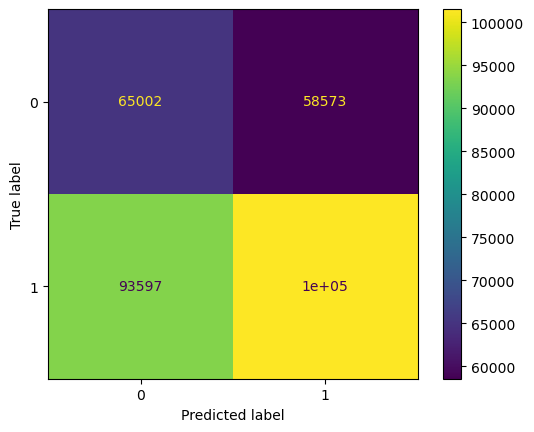

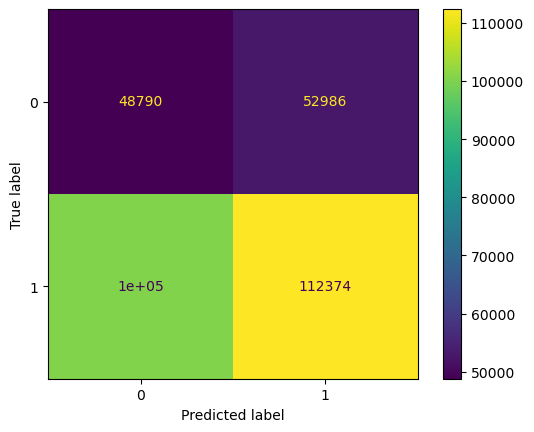

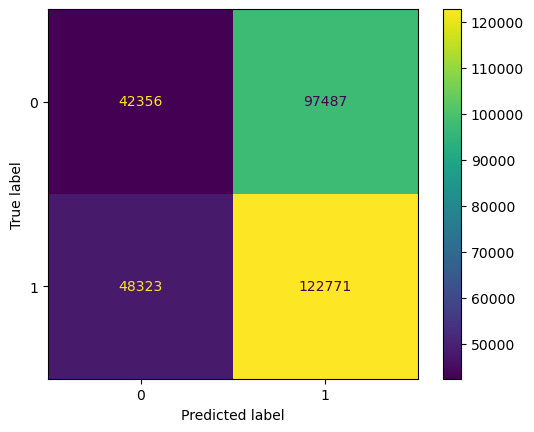

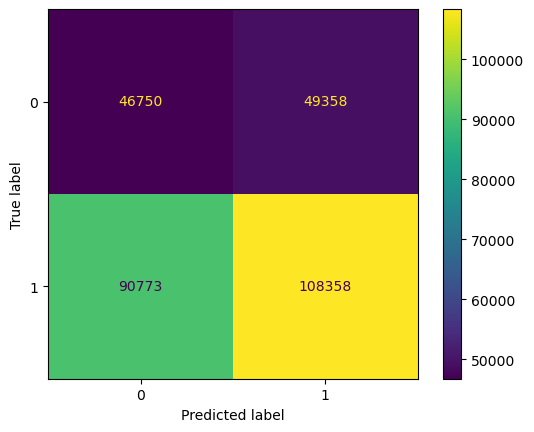

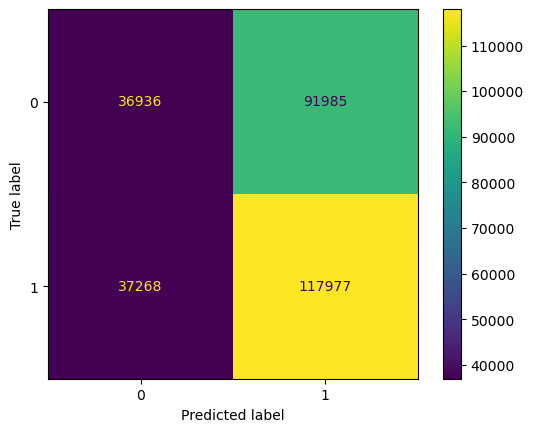

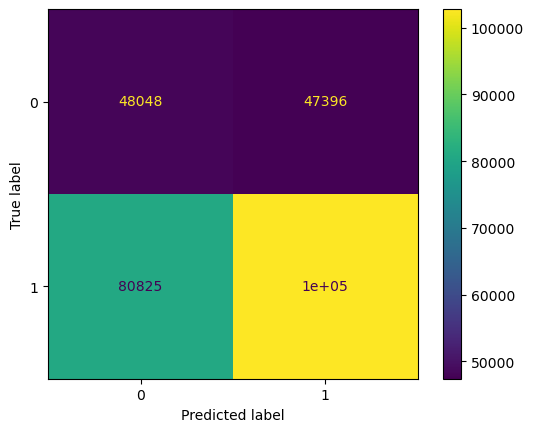

In [32]:
holding_period = 90

# make a dataframe with the metrics for each model
metrics = pd.DataFrame(columns=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'])

# evaluate the models for each starting date
for i, training_date in enumerate(training_starting_dates):

    training_date_str = training_date
    training_date = pd.to_datetime(training_date)

    start_trading_date = training_date + pd.DateOffset(years=2)
    start_trading_date_str = str(start_trading_date.date())

    first_trading_date = find_first_trading_day(start_trading_date, data, 'forward')
    last_trading_date = start_trading_date + pd.DateOffset(years=2) - pd.DateOffset(days=1)
    
    # subset the data to the period of interest
    training_data = data[(data['date'] >= start_trading_date) & (data['date'] <= last_trading_date)]

    # find the selected features for the period of interest
    training_features = features[training_date]
    training_date_str = training_date.strftime('%Y-%m-%d')
    model_name = f'xg_boost_mkIII_{training_date_str}_500_correct_dataset'

    # load model 1 as pickle
    with open(f'../../models/final_models/{model_name}.pkl', 'rb') as f:
        model1 = pkl.load(f)

    # load model 2 as pickle
    with open(f'../../models/final_models/{model_name}.pkl', 'rb') as f:
        model2 = pkl.load(f)

    X = training_data[training_features]
    y = training_data['target']

    # make predictions
    #y_pred1 = model1.predict(X)
    y_pred2 = model2.predict(X.copy())

    #metrics.loc['model1'] = [accuracy_score(y, y_pred1), roc_auc_score(y, y_pred1), f1_score(y, y_pred1), precision_score(y, y_pred1), recall_score(y, y_pred1)]
    metrics.loc[f'{start_trading_date_str}'] = [accuracy_score(y, y_pred2), roc_auc_score(y, y_pred2), f1_score(y, y_pred2), precision_score(y, y_pred2), recall_score(y, y_pred2)]

    # plot the confusion matrix
    cm = confusion_matrix(y, y_pred2)
    ConfusionMatrixDisplay(cm).plot()

# name the index
metrics.index.name = 'test_start_date'

In [33]:
# print the rounded metrics
print(metrics.round(3))

                 accuracy  roc_auc     f1  precision  recall
test_start_date                                             
2010-01-01          0.523    0.523  0.572      0.634   0.520
2012-01-01          0.513    0.504  0.595      0.680   0.528
2014-01-01          0.531    0.510  0.627      0.557   0.718
2016-01-01          0.525    0.515  0.607      0.687   0.544
2018-01-01          0.545    0.523  0.646      0.562   0.760
2020-01-01          0.541    0.532  0.616      0.684   0.560


# START OF BACKTEST

In [34]:
def subset_data_to_current(data, prediction_method, current_trading_date, num_days):
    if prediction_method == 'single_day':
                # data on the current trading date
                current_data = data[data['date'] == current_trading_date]

    elif prediction_method == 'multi_day':
        dates = [current_trading_date]
        
        while len(dates) < num_days:
            next_date = find_first_trading_day(current_trading_date, data, 'backward', consider_current_date=False)
            dates.append(next_date)
            current_trading_date = next_date
        current_data = data[data['date'].isin(dates)]

    return current_data

In [35]:
def create_prediction_df(current_data_info, y_prob):
    # create a dataframe to store the predictions and the permnos
    predictions = pd.DataFrame(
        {
            'permno': current_data_info['permno'],
            'prob_0': y_prob[:, 0],
            'prob_1': y_prob[:, 1]
        }
    )

    return predictions

In [36]:
def find_top_permnos_to_trade(predictions_df, num_permnos_to_trade, short, threshold):

    # sort the predictions by the probability of being in the positive class
    predictions_df.sort_values(by='prob_1', ascending=False, inplace=True)
    
    # find the top permnos to trade
    if type(threshold) == type(None):
        top_long_permnos = predictions_df['permno'].values[:num_permnos_to_trade[0]]
    else:
        top_long_permnos = predictions_df[predictions_df['prob_1'] >= threshold]['permno'].values

        if len(top_long_permnos) < num_permnos_to_trade[0]:
            top_long_permnos = predictions_df['permno'].values[:num_permnos_to_trade[0]]

    if not short:
        return top_long_permnos, None

    # find the bottom permnos to trade
    predictions_df.sort_values(by='prob_0', ascending=False, inplace=True)

    if type(threshold) == type(None):
        top_short_permnos = predictions_df['permno'].values[:num_permnos_to_trade[1]]
    else:
        top_short_permnos = predictions_df[predictions_df['prob_0'] >= threshold]['permno'].values

        if len(top_short_permnos) < num_permnos_to_trade[1]:
            top_short_permnos = predictions_df['permno'].values[:num_permnos_to_trade[1]]
    
    return top_long_permnos, top_short_permnos

In [37]:
def find_next_trading_day(current_date, data, holding_period):

    next_trading_date = current_date + pd.DateOffset(days=holding_period)
    next_trading_date = find_first_trading_day(next_trading_date, data, 'forward')

    return next_trading_date

In [38]:
def calculate_returns(price_data, long_permnos, short_permnos, current_trading_date, next_trading_date, short):
        
        if short:
                permnos = np.concatenate((long_permnos, short_permnos))
        else:
                permnos = long_permnos

        print('Currently in calculate returns')

        # keep only the date removing the time from the current trading date and the next trading date
        current_trading_date = current_trading_date.date()
        next_trading_date = next_trading_date.date()
        print('Current trading date:', current_trading_date)
        print('Next trading date:', next_trading_date)

        price_data['date'] = pd.to_datetime(price_data['date']).dt.date
        # create a new df with current prices
        # display(price_data.head())
        current_prices = price_data[price_data['date'] == current_trading_date].copy()
        # print(price_data[price_data['date'] == current_trading_date])

        # create a new df with next prices
        next_prices = price_data[price_data['date'] == next_trading_date].copy()

        # subset the current prices to the permnos of interest
        current_prices = current_prices[current_prices['permno'].isin(permnos)]
        # print(current_prices)

        # subset the next prices to the permnos of interest
        next_prices = next_prices[next_prices['permno'].isin(permnos)]
        # print(next_prices)

        # subsitute the date_permno column using the current trading date instead of the next trading date
        next_prices['date'] = current_trading_date
        next_prices = create_date_permno_column(next_prices)


        # merge the two dataframes
        merged_prices = current_prices.merge(next_prices, on='date_permno', suffixes=('_current', '_next'))

        # change the permno_current to permno
        merged_prices.rename(columns={'permno_current': 'permno'}, inplace=True)

        # calculate the returns
        merged_prices['return'] = (merged_prices['price_next'] - merged_prices['price_current']) / merged_prices['price_current']

        long_return_df = merged_prices[merged_prices['permno'].isin(long_permnos)]

        if not short:
                return long_return_df, None
        
        short_return_df = merged_prices[merged_prices['permno'].isin(short_permnos)]

        # find negative returns that are less than -1
        strange_returns = merged_prices[merged_prices['return'] < -1]
        
        # print rows corresponding to strange returns
        if strange_returns.shape[0] > 0:
            print('-'*50)
            print('-'*50)
            print('Strange returns:')
            print(strange_returns)
            print('-'*50)
            print('-'*50)

        cols_to_return = ['permno', 'return']
    
        return long_return_df[cols_to_return], short_return_df[cols_to_return]

In [39]:
def equal_weights(returns_df, price_data, verbose=False):

        if len(returns_df) == 0:
                return np.float64(0)
        
        # count number of nan values in the returns
        num_nan = returns_df['return'].isna().sum()

        # I don't get this??? why are you subtracting 1 * num_nan, if there is no data it's just as if we never bought it so the mean remains the same
        #avg_return = (returns_df['return'].mean() * (returns_df.shape[0] - num_nan) - (1 * num_nan))/(returns_df.shape[0])
        if verbose:
                print(returns_df['return'])
        avg_return = returns_df['return'].mean()

        return avg_return

In [40]:
def entropy_weights(returns_df, price_data, verbose=False):
    if len(returns_df) == 0:
        return np.float64(0)
    
    result_df = pd.DataFrame()
    # Extract the 'trading_date'
    trading_date = returns_df['date_current'].iloc[0]
    
    # Extract the 'permno' array
    permno_list = returns_df['permno'].unique()
    
    for permno in permno_list:
        # Filter DataFrame for each permno
        df_permno = price_data[price_data['permno'] == permno]
        df_permno.sort_values(by='date', inplace=True)
    
        # Select columns 'date' and 'price'
        df_permno = df_permno[['date', 'price']]
    
        # Rename columns
        df_permno.columns = ['date', permno]
    
        # Merge with result_df
        if result_df.empty:
            result_df = df_permno
        else:
            result_df = pd.merge(result_df, df_permno, on='date', how='outer')

    df_allpermno = result_df.set_index('date')

    # Retain only the rows corresponding to one year before the trading date
    one_year_before_trading_date = trading_date - pd.Timedelta(days=365)
    df_allpermno = df_allpermno[(df_allpermno.index >= one_year_before_trading_date) & (df_allpermno.index < trading_date)]

    # Dictionary to store KDE distributions for each permno
    kde_distributions = {}

    # Loop through permnos
    for permno_val in permno_list:
        # Filter DataFrame for each permno
        filtered_df = price_data[price_data['permno'] == permno_val]
        filtered_df.sort_values(by='date', inplace=True)
        filtered_df['ret'] = filtered_df['price'].pct_change()
        filtered_df = filtered_df[['permno', 'ret']]
        filtered_df.dropna(inplace=True)
        
        # Calculate KDE for returns
        kde = gaussian_kde(filtered_df['ret'])
        kde_distributions[permno_val] = kde

    # Define the variables
    w = cp.Variable(len(permno_list))  # Weights for distributions

    # Define the objective function
    expected_returns = np.zeros(len(permno_list))  # Placeholder for expected returns
    entropies = [cp.sum(cp.entr(cp.multiply(w[i], kde_distributions[permno_list[i]].evaluate(filtered_df['ret'])))) for i in range(len(permno_list))]
    lambdas = [0.000002] * len(permno_list)  # Placeholder for lambda parameters
    weighted_entropies = [lambdas[i] * entropies[i] for i in range(len(permno_list))]
    objective = cp.Maximize(cp.sum(cp.multiply(w, expected_returns)) + cp.sum(weighted_entropies))

    # Define the constraints
    constraints = [cp.sum(w) == 1, w >= 0, w<=0.25]  # Ensure weights sum to 1 and are non-negative

    # Formulate the problem
    problem = cp.Problem(objective, constraints)
    #print('I am solving the problem for the trading time:',trading_date , 'for the stocks: ',permno_list)
    # Solve the problem
    problem.solve()

    # Get the optimal solution
    optimal_weights = w.value

    # Compute the expected return for the optimal weights
    returns_df.drop_duplicates(subset=['permno', 'return'], inplace=True)
    if verbose:
        print(f'number of weights: {len(optimal_weights)}')
        print(optimal_weights)
        # print(returns_df[['permno', 'return']])
    returns_df['weights'] = optimal_weights
    returns_df['weighted_returns'] = returns_df['return'] * returns_df['weights']
    if verbose:
        print(returns_df[['permno', 'return', 'weights', 'weighted_returns']])
    avg_return = (returns_df['weighted_returns']).sum()

    return avg_return

In [41]:
def mean_variance_weights(returns_df, price_data, verbose=False):
    if len(returns_df) == 0:
        return np.float64(0)
        
    permno_list = returns_df['permno'].unique()
    end_date = returns_df['date_current'].iloc[0] - pd.Timedelta(days=1)
    start_date = end_date - pd.Timedelta(days=730)
    #convert end_date, start_date to datetime
    end_date = pd.to_datetime(end_date)
    start_date = pd.to_datetime(start_date)

    result_df = returns_df.copy()

    #Filtering the price_data
    price_data['date'] = pd.to_datetime(price_data['date'])
    filtered_data = price_data[(price_data['permno'].isin(permno_list)) &
                               (price_data['date'] >= start_date) &
                               (price_data['date'] <= end_date)].copy()

    mu_span = min(500, filtered_data.shape[0])
    std_span = 180

    filtered_data['price'] = pd.to_numeric(filtered_data['price'], errors='coerce')
    filtered_data = filtered_data.dropna(subset=['price'])
    #filtered_data = filtered_data.groupby(['date', 'permno'], as_index=False)['price'].mean() # Why??? We are already grouping by date and permno no point in taking a groupby 
    filtered_data = filtered_data[['date', 'permno', 'price']]
    filtered_data.drop_duplicates(inplace=True)

    pivot_data = filtered_data.pivot(index='date', columns='permno', values='price')

    portfolio_returns = pivot_data.pct_change().dropna()

    #Actual MVO
    mu = expected_returns.ema_historical_return(portfolio_returns, returns_data=True, span=mu_span)
    std = risk_models.exp_cov(portfolio_returns, returns_data=True, span=std_span)

    ef = EfficientFrontier(mu, std)
    raw_weights_minvar_exp = ef.min_volatility()

    # From the ordered dictionary compute the expected return
    # merge return_df with the raw_weights_minvar_exp on the permno
    if verbose:
        print(raw_weights_minvar_exp)
        # print(result_df[['permno', 'return']])


    weight_df = pd.DataFrame.from_dict(raw_weights_minvar_exp, orient='index', columns=['weights'])
    result_df = result_df.merge(weight_df, left_on='permno', right_index=True)
    result_df['weighted_returns'] = result_df['return'] * result_df['weights']
    if verbose:
        print(result_df[['permno', 'return', 'weights', 'weighted_returns']])
    avg_return = (result_df['weighted_returns']).sum()

    return avg_return

In [42]:
def trade(data, price_data, features, training_starting_dates, prediction_method,  num_days, weight_selector, threshold=None, holding_period=2, num_stocks=[15, 15], short=True, verbose=False):
    if type(threshold) != type(None):
        print('WARNING: Threshold is not None, num_stocks will be ignored used as minimum number of stocks.\n')
    total_return = 1
    if short:
        returns_df = pd.DataFrame(columns=['date', 'long_return', 'short_return', 'return', 'n_long', 'n_short'])
    else:
        returns_df = pd.DataFrame(columns=['date', 'return', 'n_long'])

    # evaluate the models for each starting date
    for i, training_date in enumerate(training_starting_dates):

        # convert the date to string
        training_date_str = training_date

        # convert the date to datetime
        training_date = pd.to_datetime(training_date)

        # find the start trading date
        start_trading_date = training_date + pd.DateOffset(years=2)

        # find the first trading date, which is the first date in the dataset after the start trading date
        first_trading_date = find_first_trading_day(start_trading_date, data, 'forward')

        # find the last trading date, which is the date two years after the start trading date
        last_trading_date = start_trading_date + pd.DateOffset(years=2) - pd.DateOffset(days=10)

        training_date_str = training_date.strftime('%Y-%m-%d')
        model_name = f'xg_boost_mkIII_{training_date_str}_500_correct_dataset'
        # load model 1 as pickle
        with open(f'../../models/final_models/{model_name}.pkl', 'rb') as f:
            model = pkl.load(f)

        # subset the data to the period of interest
        selected_features = features[training_date]

        current_trading_date = first_trading_date

        while current_trading_date < last_trading_date:

            current_data = subset_data_to_current(data, prediction_method, current_trading_date, num_days)
            
            current_data_info = current_data[['date', 'permno', 'target']]
            current_data = current_data[selected_features]
            
            # predict probabilities
            y_prob = model.predict_proba(current_data)

            # create a dataframe to store the predictions and the permnos
            predictions_df = create_prediction_df(current_data_info, y_prob)
            # display(predictions_df)

            # take the average of the probabilities by permno if the prediction method is multi_day
            if prediction_method == 'multi_day':
                predictions_df['prob_0'] = predictions_df.groupby('permno')['prob_0'].transform('mean')
                predictions_df['prob_1'] = predictions_df.groupby('permno')['prob_1'].transform('mean')

            #print('Predictions head:', predictions_df.head())

            # find the permnost to go long and short
            top_long_permnos, top_short_permnos = find_top_permnos_to_trade(predictions_df, num_stocks, short, threshold=threshold)

            n_long = len(top_long_permnos)
            print(f'Long stocks: {top_long_permnos}')
            print('Number of long stocks:', n_long)
            if short:
                n_short = len(top_short_permnos)
                print(f'Short stocks: {top_short_permnos}')
                print('Number of short stocks:', n_short)

            #print('Top long permnos:', top_long_permnos)

            # find the next trading date
            next_trading_date = find_next_trading_day(current_trading_date, data, holding_period)

            #print('Next trading date:', next_trading_date)

            # calculate the returns for the selected permnos
            long_return_df, short_return_df = calculate_returns(price_data, top_long_permnos, top_short_permnos, current_trading_date, next_trading_date, short)
            # display(long_return_df)

            #print('Long return df:', long_return_df.head())
            if (weight_selector != equal_weights)&(short):
                raise ValueError('Short selling is only supported with equal weights')
            long_return = weight_selector(long_return_df, price_data, verbose=verbose)
            #print(long_return)
            
            period_return = long_return * n_long
            if short:
                short_return = -weight_selector(short_return_df, price_data)
                period_return += short_return * n_short
            
            period_return = period_return / (n_long + n_short) if short else period_return / n_long

            total_return *= (1+period_return)

            print(f'Period from {current_trading_date.date()} to {next_trading_date.date()}:')
            if short:
                print(f'Long return: {(long_return*100).round(2)}%, Short return: {(short_return*100).round(2)}%, Period return: {(period_return*100).round(2)}%')
                returns_df_new = pd.DataFrame({'date': [current_trading_date.date()], 
                                               'long_return': [long_return], 
                                               'short_return': [short_return], 
                                               'return': [period_return],
                                               'n_long': [n_long],
                                               'n_short': [n_short]
                                               })
            else:
                print(f'Long return: {(long_return*100).round(2)}%, Period return: {(period_return*100).round(2)}%')
                returns_df_new = pd.DataFrame({'date': [current_trading_date.date()], 
                                               'return': [period_return],
                                               'n_long': [n_long]
                                               })


            print(f'Cumulative return at the end of the period: ' + str(((total_return-1)*100).round(2)) + '%', '\n')
 
            returns_df = pd.concat([returns_df, returns_df_new])

            current_trading_date = next_trading_date

    if short:    
        no_shorts_mask = returns_df['n_short'] == 0
        # set the short return to nan if there are no shorts
        returns_df.loc[no_shorts_mask, 'short_return'] = np.nan
    return returns_df

## BACKTESTS WITH VARIOUS WEIGHTS AND HOLDING PERIODS

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
holding_period = 90
entropy_90_returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, entropy_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999, verbose=True)


Long stocks: [45241 81774 68857 75510 87657 77182 92050 44601 89757 90319 90272 24109]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-01-04
Next trading date: 2010-04-05
number of weights: 12
[0.04188821 0.05786597 0.05625597 0.07531042 0.06709966 0.06678256
 0.14866439 0.05651983 0.17297875 0.09023762 0.05544506 0.11095156]
    permno    return   weights  weighted_returns
0    24109 -0.018031  0.041888         -0.000755
1    45241 -0.045034  0.057866         -0.002606
2    44601 -0.008141  0.056256         -0.000458
3    68857  0.141838  0.075310          0.010682
4    75510 -0.029658  0.067100         -0.001990
5    77182  0.512020  0.066783          0.034194
6    81774  0.046370  0.148664          0.006893
7    87657  0.179833  0.056520          0.010164
8    89757  0.300048  0.172979          0.051902
9    90272 -0.189771  0.090238         -0.017125
10   90319 -0.088935  0.055445         -0.004931
11   92050  0.041251  0.110952          0.00457

In [47]:
holding_period = 90
eq_90_returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, equal_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999, verbose=True)


Long stocks: [45241 81774 68857 75510 87657 77182 92050 44601 89757 90319 90272 24109]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-01-04
Next trading date: 2010-04-05
0    -0.018031
1    -0.045034
2    -0.008141
3     0.141838
4    -0.029658
5     0.512020
6     0.046370
7     0.179833
8     0.300048
9    -0.189771
10   -0.088935
11    0.041251
Name: return, dtype: float64
Period from 2010-01-04 to 2010-04-05:
Long return: 7.01%, Period return: 7.01%
Cumulative return at the end of the period: 7.01% 

Long stocks: [17279 77037 24109 90520 77481 92772 90664 92050 51706 66800 76625 17144]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-04-05
Next trading date: 2010-07-06
0    -0.055267
1     0.011011
2    -0.030603
3    -0.156250
4    -0.038505
5     0.001185
6    -0.167977
7    -0.034843
8    -0.282576
9     0.101898
10   -0.033866
11   -0.209694
Name: return, dtype: float64
Period from 2010-04-05 to 2010-07-06

In [48]:
holding_period = 90
mvop_90_returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, mean_variance_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999, verbose=True)


Long stocks: [45241 81774 68857 75510 87657 77182 92050 44601 89757 90319 90272 24109]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-01-04
Next trading date: 2010-04-05
OrderedDict([(24109, 0.234450856121416), (44601, 0.0), (45241, 0.062544297429176), (68857, 0.0), (75510, 0.0), (77182, 0.2003005648609565), (81774, 0.0), (87657, 0.342266610516173), (89757, 0.0), (90272, 0.0), (90319, 0.1604376710722784), (92050, 0.0)])
    permno    return   weights  weighted_returns
0    24109 -0.018031  0.234451         -0.004227
1    45241 -0.045034  0.062544         -0.002817
2    44601 -0.008141  0.000000         -0.000000
3    68857  0.141838  0.000000          0.000000
4    75510 -0.029658  0.000000         -0.000000
5    77182  0.512020  0.200301          0.102558
6    81774  0.046370  0.000000          0.000000
7    87657  0.179833  0.342267          0.061551
8    89757  0.300048  0.000000          0.000000
9    90272 -0.189771  0.000000         -0.000000

In [49]:
holding_period = 45
entropy_45_returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, entropy_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999, verbose=True)


Long stocks: [45241 81774 68857 75510 87657 77182 92050 44601 89757 90319 90272 24109]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-01-04
Next trading date: 2010-02-18
number of weights: 12
[0.04188821 0.05786597 0.05625597 0.07531042 0.06709966 0.06678256
 0.14866439 0.05651983 0.17297875 0.09023762 0.05544506 0.11095156]
    permno    return   weights  weighted_returns
0    24109 -0.040641  0.041888         -0.001702
1    45241 -0.083590  0.057866         -0.004837
2    44601 -0.130258  0.056256         -0.007328
3    68857  0.036087  0.075310          0.002718
4    75510 -0.103802  0.067100         -0.006965
5    77182  0.219331  0.066783          0.014647
6    81774 -0.082195  0.148664         -0.012219
7    87657  0.036698  0.056520          0.002074
8    89757  0.131623  0.172979          0.022768
9    90272 -0.248721  0.090238         -0.022444
10   90319 -0.133275  0.055445         -0.007389
11   92050 -0.010645  0.110952         -0.00118

In [50]:
holding_period = 45
eq_45_returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, equal_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999, verbose=False)


Long stocks: [45241 81774 68857 75510 87657 77182 92050 44601 89757 90319 90272 24109]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-01-04
Next trading date: 2010-02-18
Period from 2010-01-04 to 2010-02-18:
Long return: -3.41%, Period return: -3.41%
Cumulative return at the end of the period: -3.41% 

Long stocks: [81774 90272 45241 17279 89509 91392 39490 44601 89626 82598 79103 79915]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-02-18
Next trading date: 2010-04-05
Period from 2010-02-18 to 2010-04-05:
Long return: 8.63%, Period return: 8.63%
Cumulative return at the end of the period: 4.92% 

Long stocks: [17279 77037 24109 90520 77481 92772 90664 92050 51706 66800 76625 17144]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-04-05
Next trading date: 2010-05-20
Period from 2010-04-05 to 2010-05-20:
Long return: -6.08%, Period return: -6.08%
Cumulative return at the end of 

In [51]:
holding_period = 45
mvop_45_returns_df = trade(data, price_data, features, training_starting_dates, 
                   'single_day', 1, mean_variance_weights, num_stocks=[12, 0], 
                   short=False, holding_period=holding_period, threshold=0.999, verbose=True)


Long stocks: [45241 81774 68857 75510 87657 77182 92050 44601 89757 90319 90272 24109]
Number of long stocks: 12
Currently in calculate returns
Current trading date: 2010-01-04
Next trading date: 2010-02-18
OrderedDict([(24109, 0.234450856121416), (44601, 0.0), (45241, 0.062544297429176), (68857, 0.0), (75510, 0.0), (77182, 0.2003005648609565), (81774, 0.0), (87657, 0.342266610516173), (89757, 0.0), (90272, 0.0), (90319, 0.1604376710722784), (92050, 0.0)])
    permno    return   weights  weighted_returns
0    24109 -0.040641  0.234451         -0.009528
1    45241 -0.083590  0.062544         -0.005228
2    44601 -0.130258  0.000000         -0.000000
3    68857  0.036087  0.000000          0.000000
4    75510 -0.103802  0.000000         -0.000000
5    77182  0.219331  0.200301          0.043932
6    81774 -0.082195  0.000000         -0.000000
7    87657  0.036698  0.342267          0.012561
8    89757  0.131623  0.000000          0.000000
9    90272 -0.248721  0.000000         -0.000000

In [52]:
# saving the backtests to csvs so I don't have to rerun them
entropy_90_returns_df.to_csv('../../data/backtest/entropy_90_returns_df.csv')
eq_90_returns_df.to_csv('../../data/backtest/eq_90_returns_df.csv')
mvop_90_returns_df.to_csv('../../data/backtest/mvop_90_returns_df.csv')
entropy_45_returns_df.to_csv('../../data/backtest/entropy_45_returns_df.csv')
eq_45_returns_df.to_csv('../../data/backtest/eq_45_returns_df.csv')
mvop_45_returns_df.to_csv('../../data/backtest/mvop_45_returns_df.csv')

### CALCULATING RESULTS AND STATS

In [53]:
import mpl_bsic as bsic

In [54]:
backtests = [entropy_90_returns_df, eq_90_returns_df, mvop_90_returns_df, entropy_45_returns_df, eq_45_returns_df, mvop_45_returns_df]
backtest_names = ['entropy_90', 'eq_90', 'mvop_90', 'entropy_45', 'eq_45', 'mvop_45']
backtest_dict = dict(zip(backtest_names, backtests))

In [56]:
# find geometric mean of (returns_df['return'] + 1)
for name, df in backtest_dict.items():
    geometric_mean = df['return'].add(1).prod()**(1/len(df['return'])) - 1
    print(f'{name} average return per period: {geometric_mean}')
    yearly_return = df['return'].add(1).prod()**(1/12) - 1
    print(f'{name} average return per year: {yearly_return}')
    print('')

entropy_90 average return per period: 0.03363634321636311
entropy_90 average return per year: 0.14148729956653971

eq_90 average return per period: 0.04385413616529532
eq_90 average return per year: 0.18729671336838916

mvop_90 average return per period: 0.037752813767473414
mvop_90 average return per year: 0.15978016872135936

entropy_45 average return per period: 0.030052995557766637
entropy_45 average return per year: 0.267291598107984

eq_45 average return per period: 0.02802878504331474
eq_45 average return per year: 0.24750473128154216

mvop_45 average return per period: 0.020540218755325856
mvop_45 average return per year: 0.1766329254316068



In [57]:
for name, returns_df in backtest_dict.items():
    print("\u0332".join(f'Statistics referring to {name}:'))
    print('Average return per period:', returns_df['return'].add(1).prod()**(1/len(returns_df['return'])) - 1)
    print('Average return per year:', returns_df['return'].add(1).prod()**(1/12) - 1)
    print('Standard deviation of returns:', returns_df['return'].std())
    print('Sharpe ratio:', (returns_df['return'].mean() / returns_df['return'].std()) * np.sqrt(365/holding_period))
    print('')

    if 'long_return' in returns_df.columns:
        print('Average long return:', returns_df['long_return'].mean())
        print('Standard deviation of long returns:', returns_df['long_return'].std())
        print('Sharpe ratio of long returns:', (returns_df['long_return'].mean() / returns_df['long_return'].std()) * np.sqrt(365/holding_period))
        print('')

    if 'short_return' in returns_df.columns:
        print('Average short return:', returns_df['short_return'].mean())
        print('Standard deviation of short returns:', returns_df['short_return'].std())
        print('Sharpe ratio of short returns:', (returns_df['short_return'].mean() / returns_df['short_return'].std()) * np.sqrt(365/holding_period))
        print('')

    # find annual returns grouping by year
    returns_df['date'] = pd.to_datetime(returns_df['date'])
    returns_df['year'] = returns_df['date'].dt.year
    returns_df['return_to_multiply'] = returns_df['return'] + 1

    annaul_returns = returns_df.copy()
    annaul_returns = annaul_returns.groupby('year')['return_to_multiply'].prod() - 1

    print('Annual returns:', annaul_returns)
    print('')

S̲t̲a̲t̲i̲s̲t̲i̲c̲s̲ ̲r̲e̲f̲e̲r̲r̲i̲n̲g̲ ̲t̲o̲ ̲e̲n̲t̲r̲o̲p̲y̲_̲9̲0̲:
Average return per period: 0.03363634321636311
Average return per year: 0.14148729956653971
Standard deviation of returns: 0.12662346372981523
Sharpe ratio: 0.9351839297102661

Annual returns: year
2010    0.320488
2011   -0.358377
2012    0.247170
2013    0.402174
2014    0.158170
2015   -0.169082
2016    0.135916
2017    0.378452
2018    0.362158
2019   -0.013334
2020    0.646588
2021   -0.009488
Name: return_to_multiply, dtype: float64

S̲t̲a̲t̲i̲s̲t̲i̲c̲s̲ ̲r̲e̲f̲e̲r̲r̲i̲n̲g̲ ̲t̲o̲ ̲e̲q̲_̲9̲0̲:
Average return per period: 0.04385413616529532
Average return per year: 0.18729671336838916
Standard deviation of returns: 0.09597168877916154
Sharpe ratio: 1.433776715288482

Annual returns: year
2010    0.283408
2011   -0.072488
2012    0.281782
2013    0.322499
2014    0.238233
2015   -0.081194
2016    0.125343
2017    0.335294
2018    0.470877
2019    0.096479
2020    0.404938
2021    0.003912
Name: return_to_multiply,

In [60]:
from pandas import to_datetime
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed

fonts already added so will not add again


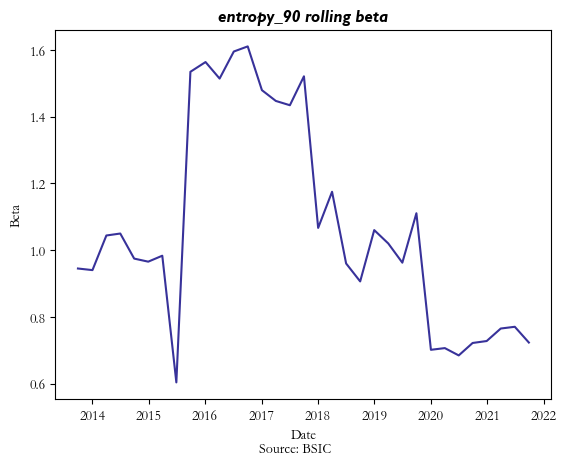

[*********************100%%**********************]  1 of 1 completed

fonts already added so will not add again


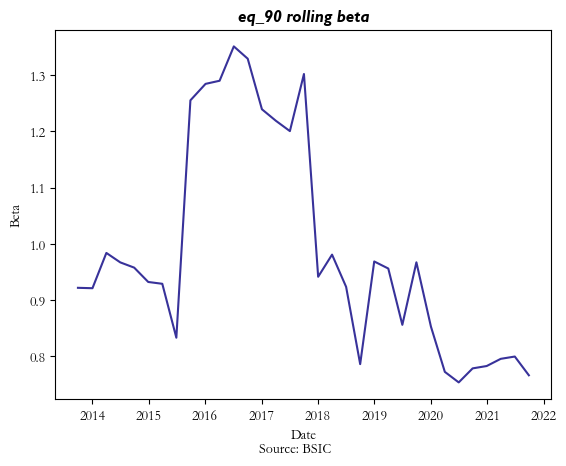

[*********************100%%**********************]  1 of 1 completed


fonts already added so will not add again


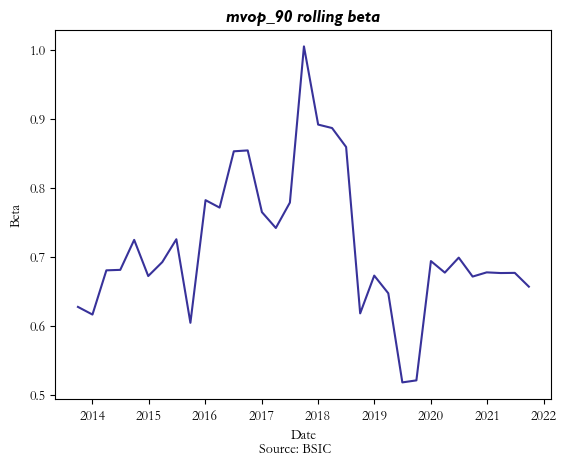

[*********************100%%**********************]  1 of 1 completed

fonts already added so will not add again


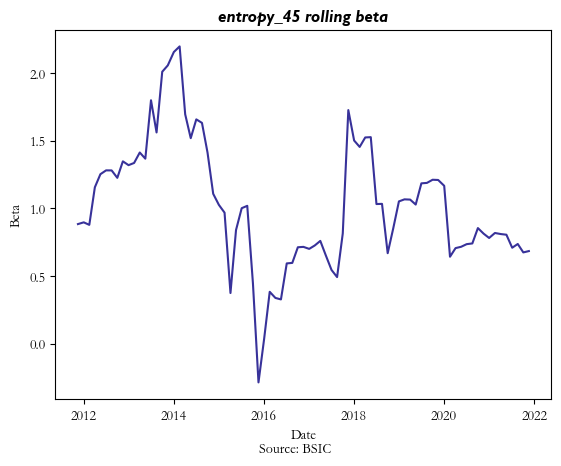

[*********************100%%**********************]  1 of 1 completed


fonts already added so will not add again


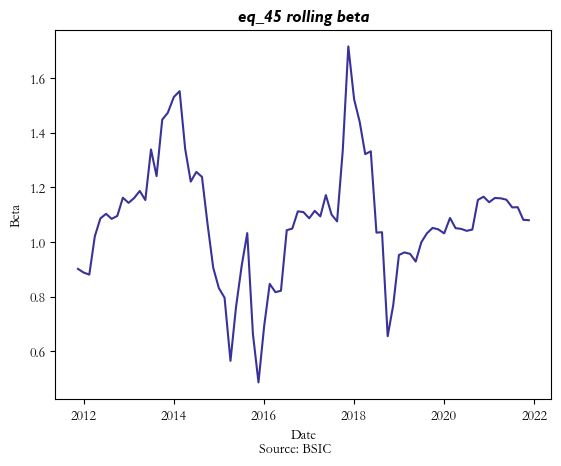

[*********************100%%**********************]  1 of 1 completed


fonts already added so will not add again


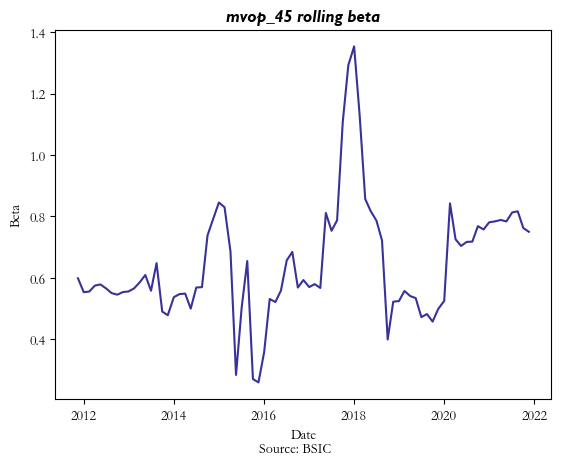

In [63]:
for name, returns_df in backtest_dict.items():
    spy_data = yf.download("SPY", start="2008-01-01", end="2022-01-01")
    spy_data.index = pd.to_datetime(spy_data.index)

    # take intersection between date in returns_df and spy_data
    returns_df['date'] = pd.to_datetime(returns_df['date'])
    dates = list(set(returns_df['date'].dt.date) & set(spy_data.index.date))
    dates.append(pd.to_datetime('2021-12-31'))
    spy_data = spy_data.loc[dates]
    spy_data.sort_index(inplace=True)
    spy_data['Return'] = spy_data['Close'].pct_change()
    # lag the return by one day
    spy_data['Return'] = spy_data['Return'].shift(-1)
    spy_data = spy_data[['Close', 'Return']]
    spy_data.dropna(inplace=True)

    # calculate beta for the strategy.
    covariance = np.cov(returns_df.set_index('date')['return'], spy_data['Return'])
    spy_variance = np.var(spy_data['Return'])
    beta = covariance[0, 1] / spy_variance

    # calculate the rolling 2 year beta
    holding_period = 45
    rolling_period = round(2*365/holding_period)
    rolling_cov = returns_df.set_index('date')['return'].rolling(window=rolling_period).cov(spy_data['Return'])
    rolling_spy_var = spy_data['Return'].rolling(window=rolling_period).var()

    rolling_beta = rolling_cov / rolling_spy_var
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #     print(rolling_beta)
    
    fig, ax = plt.subplots()
    ax.plot(rolling_beta)
    ax.set_title(f'{name} rolling beta')
    ax.set_xlabel('Date')
    ax.set_ylabel('Beta')
    bsic.apply_bsic_style(fig, ax)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

date
2010-01-04         NaN
2010-04-05         NaN
2010-07-06         NaN
2010-10-04         NaN
2011-01-03         NaN
2011-04-04         NaN
2011-07-05         NaN
2011-10-03   -0.095030
2012-01-03   -0.006767
2012-04-02   -0.048371
2012-07-02   -0.112977
2012-10-01   -0.463564
2012-12-31   -0.387659
2013-04-01   -0.159787
2013-07-01    0.474051
2013-09-30    1.479938
2014-01-02    1.162863
2014-04-02         NaN
2014-07-01         NaN
2014-09-29         NaN
2014-12-29         NaN
2015-03-30         NaN
2015-06-29         NaN
2015-09-28         NaN
2016-01-04    1.843732
2016-04-04    1.695348
2016-07-05    1.734143
2016-10-03    1.486336
2017-01-03    1.105167
2017-04-03    1.138820
2017-07-03    1.324749
2017-10-02    1.680817
2018-01-02    2.482341
2018-04-02    4.430592
2018-07-02    2.608992
2018-10-01    1.195384
2018-12-31    1.412190
2019-04-01    1.000214
2019-07-01    0.523810
2019-09-30    0.603689
2020-01-02    0.327693
2020-04-01         NaN
2020-06-30         NaN
2020-0

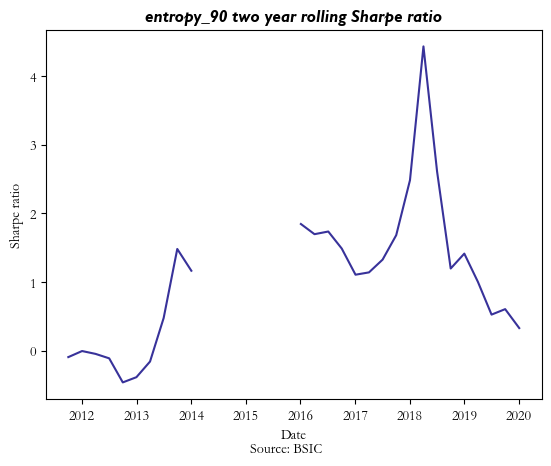

[*********************100%%**********************]  1 of 1 completed


date
2010-01-04         NaN
2010-04-05         NaN
2010-07-06         NaN
2010-10-04         NaN
2011-01-03         NaN
2011-04-04         NaN
2011-07-05         NaN
2011-10-03    0.413750
2012-01-03    0.528527
2012-04-02    0.579320
2012-07-02    0.427733
2012-10-01    0.108936
2012-12-31    0.147758
2013-04-01    0.344285
2013-07-01    1.429343
2013-09-30    1.796442
2014-01-02    1.465191
2014-04-02         NaN
2014-07-01         NaN
2014-09-29         NaN
2014-12-29         NaN
2015-03-30         NaN
2015-06-29         NaN
2015-09-28         NaN
2016-01-04    1.740155
2016-04-04    1.449393
2016-07-05    1.645053
2016-10-03    1.386087
2017-01-03    1.129451
2017-04-03    1.137896
2017-07-03    1.387276
2017-10-02    1.667131
2018-01-02    2.408336
2018-04-02    4.280063
2018-07-02    4.761097
2018-10-01    1.948591
2018-12-31    1.864230
2019-04-01    1.431451
2019-07-01    1.084887
2019-09-30    1.156183
2020-01-02    0.504751
2020-04-01         NaN
2020-06-30         NaN
2020-0

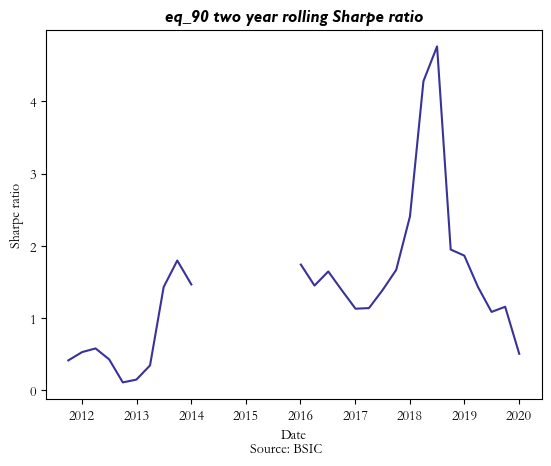

[*********************100%%**********************]  1 of 1 completed


date
2010-01-04         NaN
2010-04-05         NaN
2010-07-06         NaN
2010-10-04         NaN
2011-01-03         NaN
2011-04-04         NaN
2011-07-05         NaN
2011-10-03    1.059627
2012-01-03    0.766793
2012-04-02    0.811819
2012-07-02    0.528158
2012-10-01    0.404996
2012-12-31    0.323542
2013-04-01    0.574157
2013-07-01    1.047203
2013-09-30    0.777690
2014-01-02    0.976284
2014-04-02         NaN
2014-07-01         NaN
2014-09-29         NaN
2014-12-29         NaN
2015-03-30         NaN
2015-06-29         NaN
2015-09-28         NaN
2016-01-04    1.092241
2016-04-04    1.266183
2016-07-05    1.434818
2016-10-03    1.287064
2017-01-03    0.809829
2017-04-03    1.267301
2017-07-03    2.598277
2017-10-02    2.368868
2018-01-02    1.951648
2018-04-02    2.040697
2018-07-02    2.068595
2018-10-01    1.261395
2018-12-31    1.785047
2019-04-01    1.661940
2019-07-01    1.844138
2019-09-30    1.830196
2020-01-02    0.442738
2020-04-01         NaN
2020-06-30         NaN
2020-0

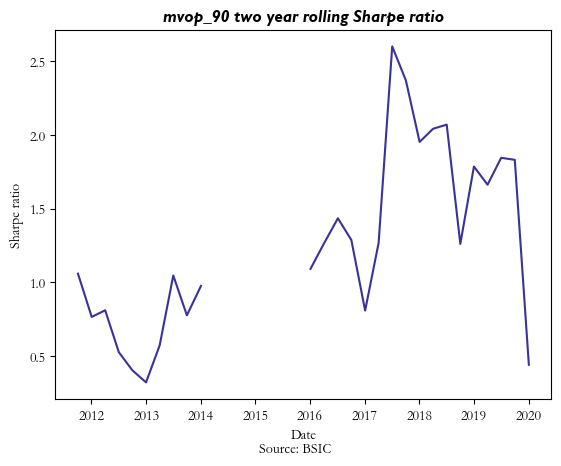

[*********************100%%**********************]  1 of 1 completed


date
2010-01-04         NaN
2010-02-18         NaN
2010-04-05         NaN
2010-05-20         NaN
2010-07-06         NaN
2010-08-20         NaN
2010-10-04         NaN
2010-11-18         NaN
2011-01-03         NaN
2011-02-17         NaN
2011-04-04         NaN
2011-05-19         NaN
2011-07-05         NaN
2011-08-19         NaN
2011-10-03         NaN
2011-11-17    0.314052
2012-01-03    0.534737
2012-02-17    0.440240
2012-04-02    0.059175
2012-05-17    0.213240
2012-07-02    0.327420
2012-08-16    0.167320
2012-10-01   -0.130451
2012-11-15    0.156710
2012-12-31    0.126016
2013-02-14    0.176208
2013-04-01    0.319906
2013-05-16    0.416195
2013-07-01    0.632630
2013-08-15    1.115227
2013-09-30    1.218000
2013-11-14    1.228077
2014-01-02    1.162655
2014-02-18    1.195852
2014-04-04    2.148335
2014-05-19    1.908440
2014-07-03    1.458786
2014-08-18    1.551360
2014-10-02    1.748229
2014-11-17    1.358705
2015-01-02    1.279991
2015-02-17    1.166089
2015-04-06    0.801232
2015-0

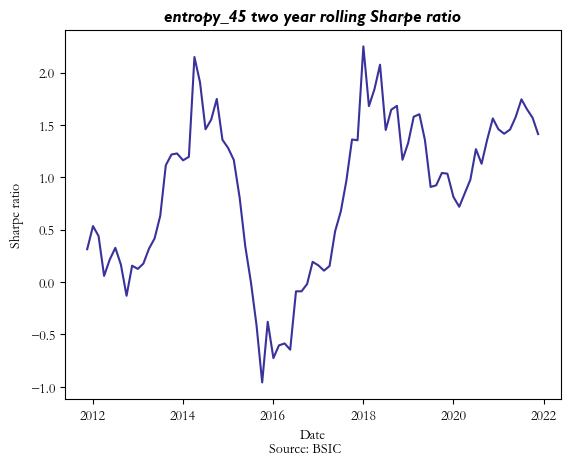

[*********************100%%**********************]  1 of 1 completed


date
2010-01-04         NaN
2010-02-18         NaN
2010-04-05         NaN
2010-05-20         NaN
2010-07-06         NaN
2010-08-20         NaN
2010-10-04         NaN
2010-11-18         NaN
2011-01-03         NaN
2011-02-17         NaN
2011-04-04         NaN
2011-05-19         NaN
2011-07-05         NaN
2011-08-19         NaN
2011-10-03         NaN
2011-11-17    0.736112
2012-01-03    1.027485
2012-02-17    0.958672
2012-04-02    0.651664
2012-05-17    0.826111
2012-07-02    0.907584
2012-08-16    0.662693
2012-10-01    0.377622
2012-11-15    0.537975
2012-12-31    0.523235
2013-02-14    0.561298
2013-04-01    0.641581
2013-05-16    0.742657
2013-07-01    1.217658
2013-08-15    1.617119
2013-09-30    1.617115
2013-11-14    1.552898
2014-01-02    1.466004
2014-02-18    1.387704
2014-04-04    2.292962
2014-05-19    2.096425
2014-07-03    1.694033
2014-08-18    1.772042
2014-10-02    2.345198
2014-11-17    2.096428
2015-01-02    2.061613
2015-02-17    1.841910
2015-04-06    1.945213
2015-0

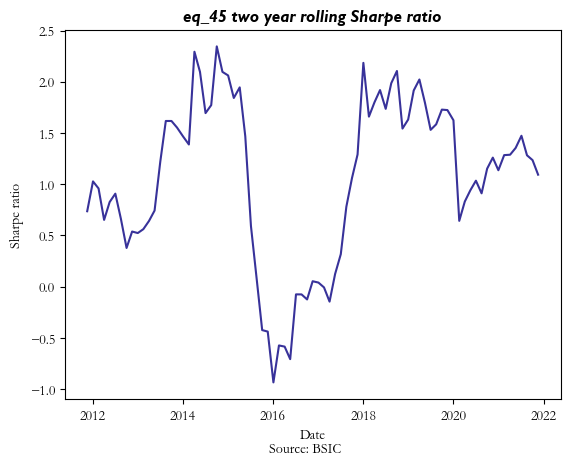

[*********************100%%**********************]  1 of 1 completed

date
2010-01-04         NaN
2010-02-18         NaN
2010-04-05         NaN
2010-05-20         NaN
2010-07-06         NaN
2010-08-20         NaN
2010-10-04         NaN
2010-11-18         NaN
2011-01-03         NaN
2011-02-17         NaN
2011-04-04         NaN
2011-05-19         NaN
2011-07-05         NaN
2011-08-19         NaN
2011-10-03         NaN
2011-11-17    1.287849
2012-01-03    1.159941
2012-02-17    1.085594
2012-04-02    1.078480
2012-05-17    1.338848
2012-07-02    1.169606
2012-08-16    1.020707
2012-10-01    0.854758
2012-11-15    0.876651
2012-12-31    0.921925
2013-02-14    1.082863
2013-04-01    1.256539
2013-05-16    1.008604
2013-07-01    1.569500
2013-08-15    1.312618
2013-09-30    1.181159
2013-11-14    1.042878
2014-01-02    1.376567
2014-02-18    1.335291
2014-04-04    1.739511
2014-05-19    1.593836
2014-07-03    1.460273
2014-08-18    1.329737
2014-10-02    1.696937
2014-11-17    1.419219
2015-01-02    1.147743
2015-02-17    0.797909
2015-04-06    0.562295
2015-0

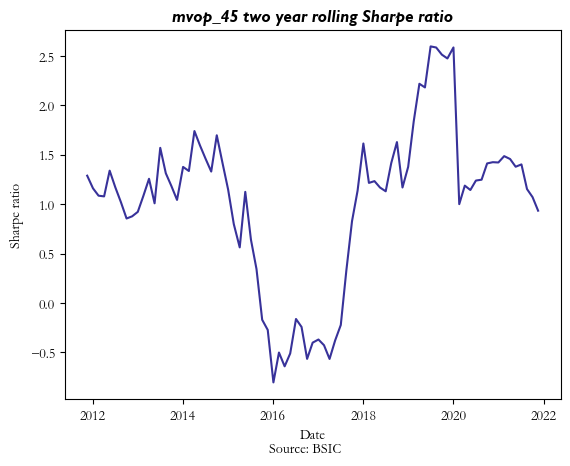

In [65]:
# compute sharpe
for name, returns_df in backtest_dict.items():
    tnx_ticker = "^TNX"
    returns_df['date'] = pd.to_datetime(returns_df['date'])
    dates = list(set(returns_df['date'].dt.date) & set(spy_data.index.date))
    dates.append(pd.to_datetime('2021-12-31'))
    # Load historical price data from Yahoo Finance
    tnx_data = yf.download(tnx_ticker, start="2008-01-01", end="2022-01-01")
    tnx_data.index = pd.to_datetime(tnx_data.index)
    tnx_data = tnx_data.loc[dates].sort_index()
    tnx_data = tnx_data[['Adj Close']]/100
    #shift by one period to get expected risk free rate for the next period
    tnx_data = tnx_data.shift(-1)
    tnx_data

    # calculate the two year rolling sharpe ratio
    holding_period = int(name[-2:])
    rolling_period = round(2*365/holding_period)

    #risk-free adjusted return
    risk_free_ret = pd.merge(tnx_data*45/365, returns_df, left_index=True, right_on='date')
    risk_free_ret['risk_free_adjusted_return'] = risk_free_ret['return'] - risk_free_ret['Adj Close']
    rolling_sharpe = risk_free_ret.set_index('date')['risk_free_adjusted_return'].rolling(window=rolling_period).mean()/ returns_df.set_index('date')['return'].rolling(window=rolling_period).std() * np.sqrt(365/holding_period)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(rolling_sharpe)

    # count the number of nan values in the rolling sharpe ratio
    num_nan = rolling_sharpe.isna().sum()
    num_nan

    fig, ax = plt.subplots()
    ax.plot(rolling_sharpe)
    ax.set_title(f'{name} two year rolling Sharpe ratio')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sharpe ratio')
    bsic.apply_bsic_style(fig, ax)
    plt.show()

fonts already added so will not add again


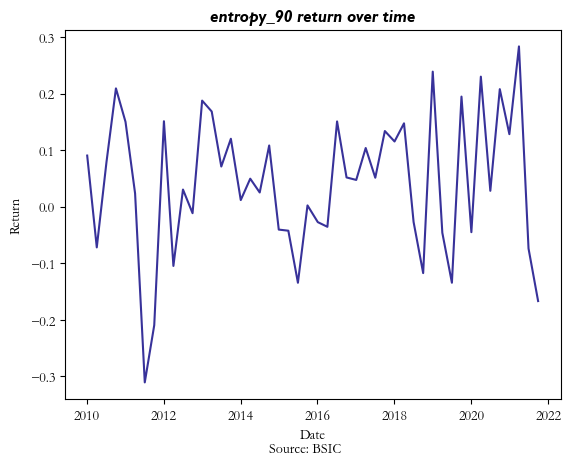

fonts already added so will not add again


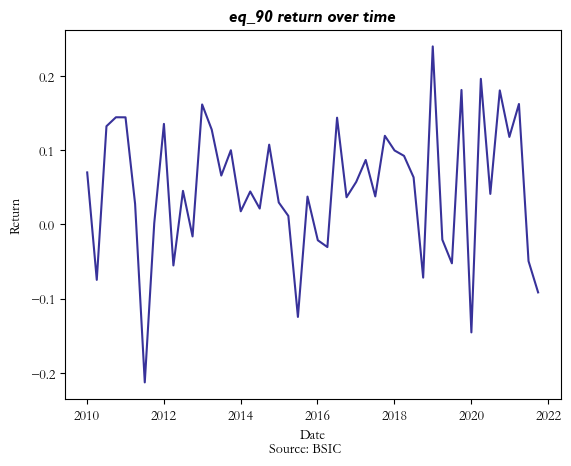

fonts already added so will not add again


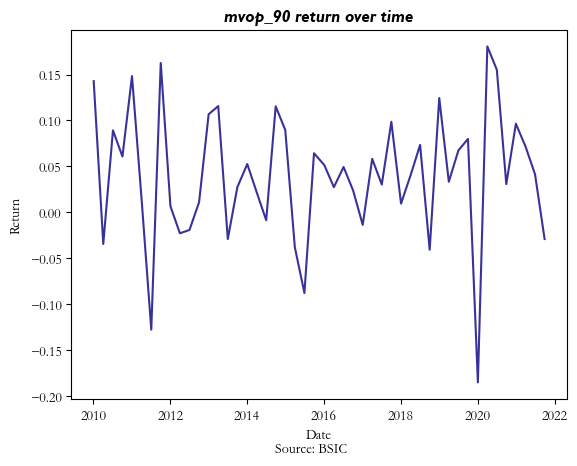

fonts already added so will not add again


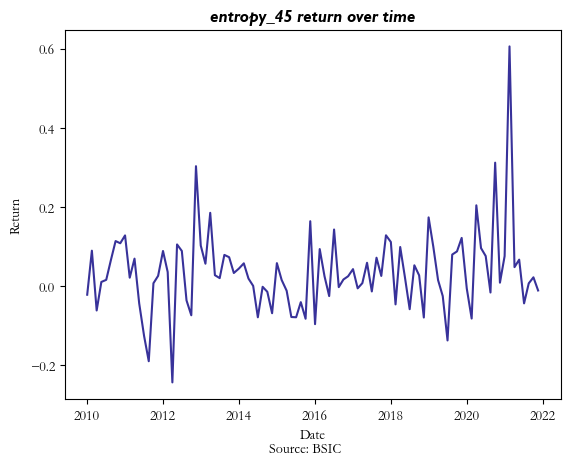

fonts already added so will not add again


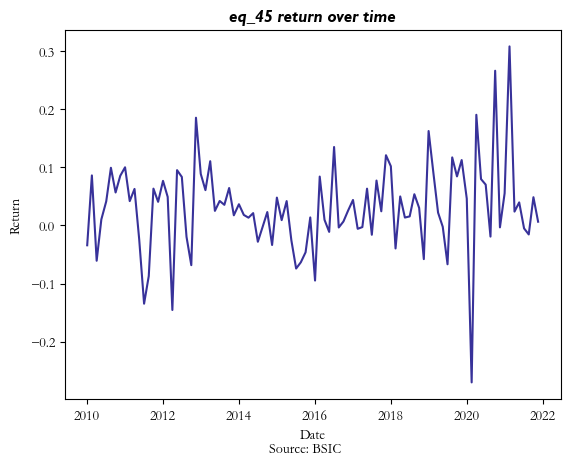

fonts already added so will not add again


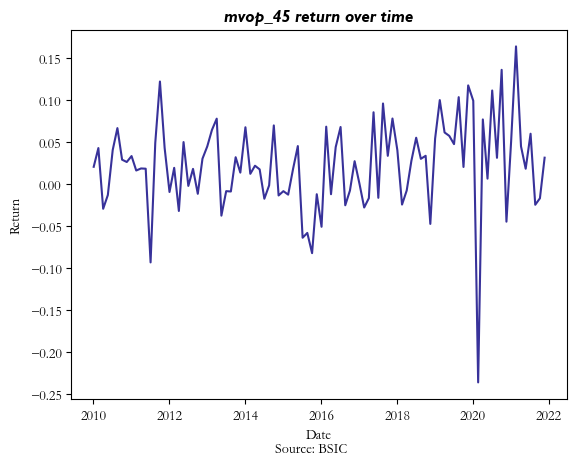

In [66]:
for name, returns_df in backtest_dict.items():
    # plot return against date
    fig, ax = plt.subplots()
    ax.plot(returns_df['date'], returns_df['return'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.set_title(f'{name} return over time')
    bsic.apply_bsic_style(fig, ax)
    plt.show()

fonts already added so will not add again


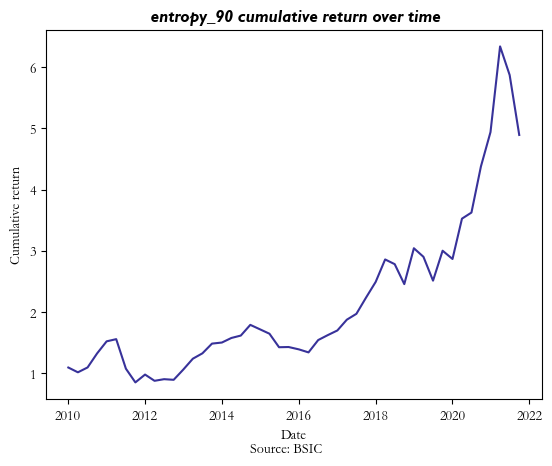

fonts already added so will not add again


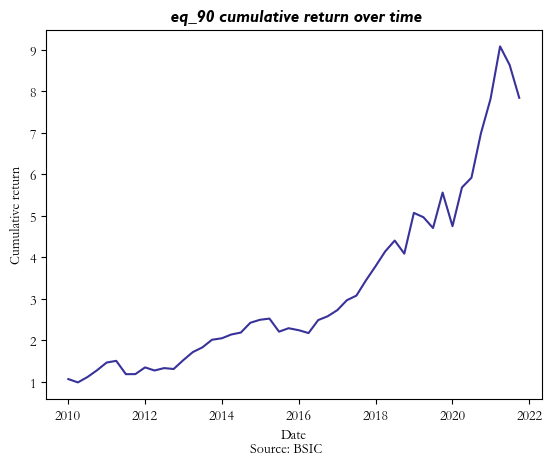

fonts already added so will not add again


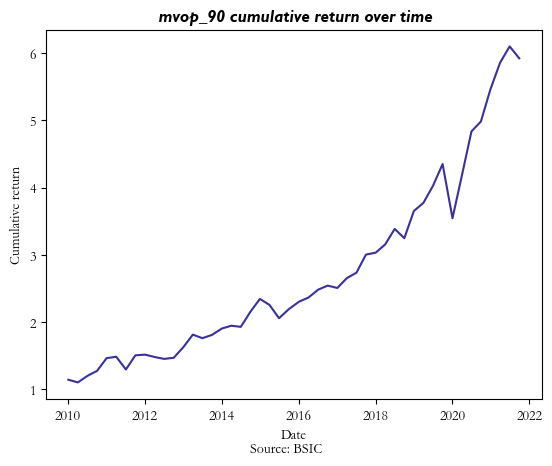

fonts already added so will not add again


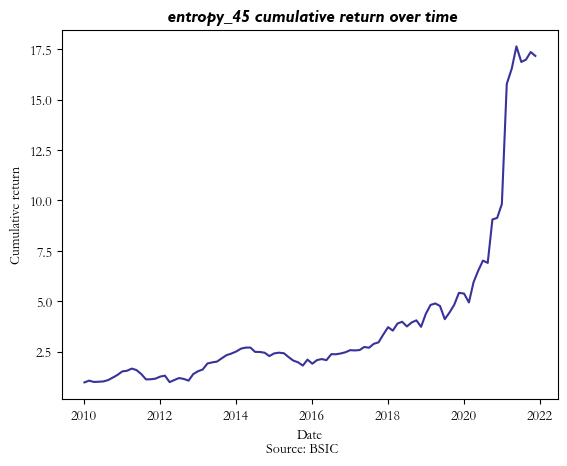

fonts already added so will not add again


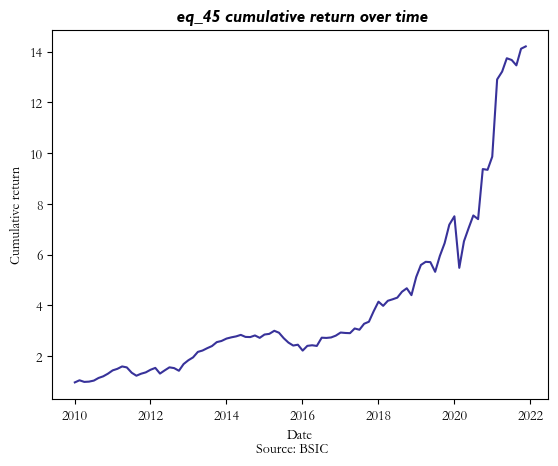

fonts already added so will not add again


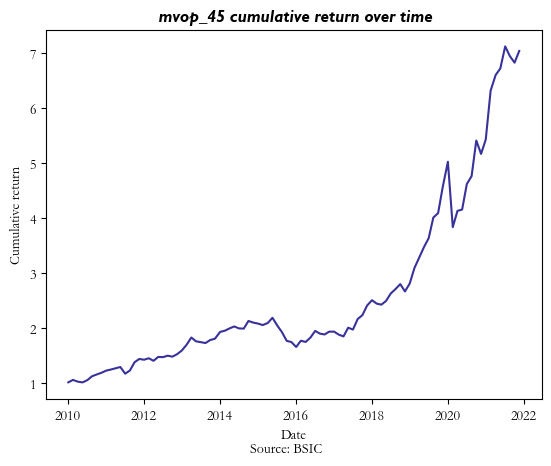

In [67]:
for name, returns_df in backtest_dict.items():
    returns_df['cumpound_return'] = returns_df['return'].add(1).cumprod()

    # plot cumulative return against date
    fig, ax = plt.subplots()
    ax.plot(returns_df['date'], returns_df['cumpound_return'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative return')
    ax.set_title(f' {name} cumulative return over time')
    bsic.apply_bsic_style(fig, ax)
    plt.show()
